In [1]:
# pip install numpy==1.23.5 seaborn

In [2]:
# sc master - running locally
sc.master

'local[*]'

In [3]:
import warnings
import pandas as pd
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

In [4]:
sc = spark.sparkContext

In [5]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, DateType, BooleanType

dataPath = "/CA1/data/TMDB_movie_dataset_v2.csv"
# schema = StructType([
#     StructField("id", IntegerType(), True),
#     StructField("title", StringType(), True),
#     StructField("vote_average", FloatType(), True),
#     StructField("vote_count", IntegerType(), True),
#     StructField("status", StringType(), True),
#     StructField("release_date", DateType(), True),
#     StructField("runtime", IntegerType(), True),
#     StructField("adult", BooleanType(), True),
#     StructField("budget", IntegerType(), True),
#     StructField("popularity", FloatType(), True),
# ])
moviesDF = spark.read.option("multiline", "true").option("quote", '"').option("header", "true").option("escape", "\\").option("escape", '"').csv(dataPath ,header=True)

moviesDF = moviesDF.withColumn("popularity", moviesDF["popularity"].cast("float"))
moviesDF = moviesDF.withColumn("id", moviesDF["id"].cast("int"))
moviesDF = moviesDF.withColumn("vote_average", moviesDF["vote_average"].cast("float"))
moviesDF = moviesDF.withColumn("vote_count", moviesDF["vote_count"].cast("int"))
moviesDF = moviesDF.withColumn("release_date", moviesDF["release_date"].cast("date"))
moviesDF = moviesDF.withColumn("runtime", moviesDF["runtime"].cast("int"))
moviesDF = moviesDF.withColumn("adult", moviesDF["adult"].cast("boolean"))
moviesDF = moviesDF.withColumn("budget", moviesDF["budget"].cast("int"))
moviesDF = moviesDF.withColumn("revenue", moviesDF["revenue"].cast("int"))

moviesDF.printSchema()

root
 |-- id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- vote_average: float (nullable = true)
 |-- vote_count: integer (nullable = true)
 |-- status: string (nullable = true)
 |-- release_date: date (nullable = true)
 |-- revenue: integer (nullable = true)
 |-- runtime: integer (nullable = true)
 |-- adult: boolean (nullable = true)
 |-- backdrop_path: string (nullable = true)
 |-- budget: integer (nullable = true)
 |-- homepage: string (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: float (nullable = true)
 |-- poster_path: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- spoken_languages: string (nullable = true)



In [6]:
moviesDF.select("title", "genres").show(2)

+------------+--------------------+
|       title|              genres|
+------------+--------------------+
|   Inception|Action, Science F...|
|Interstellar|Adventure, Drama,...|
+------------+--------------------+
only showing top 2 rows



In [7]:
moviesDF.count()

934745

In [8]:
numericalColumns = ['vote_average', 'vote_count', 'revenue', 'runtime', 'budget', 'popularity']

In [9]:
moviesDF.select(numericalColumns).toPandas().describe()

,vote_average,vote_count,revenue,runtime,budget,popularity
count,934745.000000,934745.000000,9.347410e+05,934745.000000,9.347450e+05,934745.000000
mean,2.232957,22.939624,7.671959e+05,51.889123,3.061706e+05,1.424210
std,3.152949,351.094674,1.716210e+07,62.425681,5.058921e+06,8.349914
min,0.000000,0.000000,-1.200000e+01,0.000000,0.000000e+00,0.000000
25%,0.000000,0.000000,0.000000e+00,2.000000,0.000000e+00,0.600000
50%,0.000000,0.000000,0.000000e+00,39.000000,0.000000e+00,0.600000
75%,5.294000,1.000000,0.000000e+00,90.000000,0.000000e+00,0.958000
max,10.000000,34495.000000,2.068224e+09,14400.000000,8.880000e+08,2994.356934


### Missing Values

In [10]:
import pyspark.sql.functions as fn

missingDF = moviesDF.agg(*[
    (1 - (fn.count(c) / fn.count('*'))).alias(c + '_miss')
    for c in moviesDF.columns
]).toPandas()

In [11]:
missingDF.melt()

,variable,value
0,id_miss,0.000000
1,title_miss,0.000012
2,vote_average_miss,0.000000
3,vote_count_miss,0.000000
4,status_miss,0.000000
5,release_date_miss,0.090429
6,revenue_miss,0.000004
7,runtime_miss,0.000000
8,adult_miss,0.000000
9,backdrop_path_miss,0.705277


In [13]:
moviesDF.select([fn.count(fn.when(fn.col(c).isNull(), c)).alias(c) for c in moviesDF.columns]).toPandas().melt()

,variable,value
0,id,0
1,title,11
2,vote_average,0
3,vote_count,0
4,status,0
5,release_date,84528
6,revenue,4
7,runtime,0
8,adult,0
9,backdrop_path,659254


### Correlation

In [12]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
import seaborn as sns

# intFields = spark.sql("SELECT vote_average, vote_count, revenue, runtime, budget, popularity, release_year FROM movies")
def plotCorrelation (df): 
    intFields = moviesDF.select(numericalColumns)

    # Fill all the null values with 0 so that it wont cause an error in the correlation matrix
    intFields = intFields.fillna(0)

    assembler = VectorAssembler(inputCols = numericalColumns, outputCol = "features")
    dfAssembled = assembler.transform(intFields).select("features")

    matrix = Correlation.corr(dfAssembled, "features").collect()[0][0]
    corrMatrix = matrix.toArray().tolist()

    # corrDF = spark.createDataFrame(corrMatrix, cols)
    corrDF = pd.DataFrame(data = corrMatrix, columns = numericalColumns)

    plt.figure(figsize = (16,5))
    sns.heatmap(corrDF,
                xticklabels = corrDF.columns.values,
                yticklabels = corrDF.columns.values,
                cmap = "Greens",
                annot = True
               )

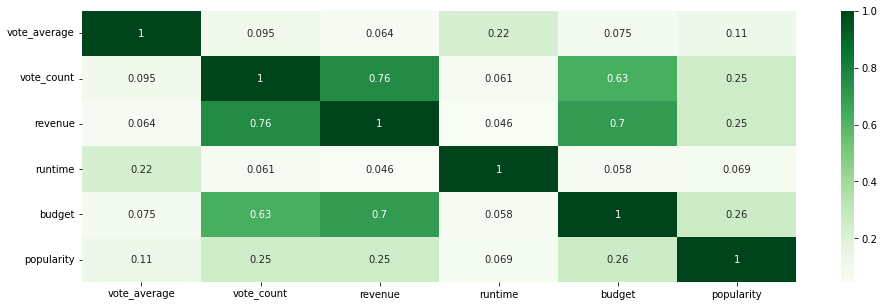

In [13]:
plotCorrelation(moviesDF)

### Histogram

In [14]:
def plotHistogram (df):
    numBins = 10

    for column in numericalColumns:
        tempPanda = df.select(column).toPandas()

        plt.figure(figsize = (8,6))
        sns.histplot(data = tempPanda, x = column, bins = numBins)
        plt.xlabel(column)
        plt.ylabel("Frequency")
        plt.title(f"Histogram of {column}")
        plt.show()

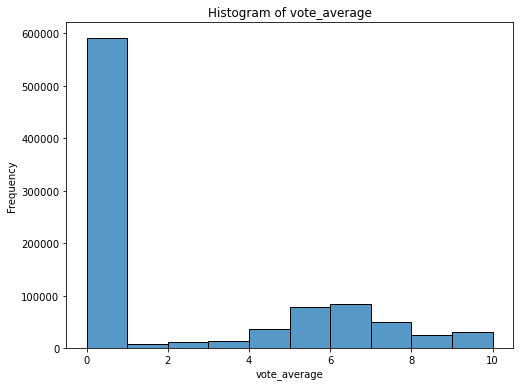

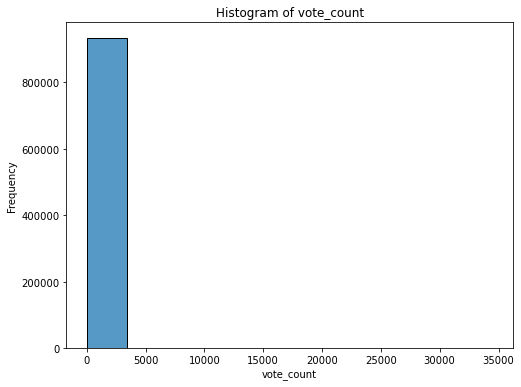

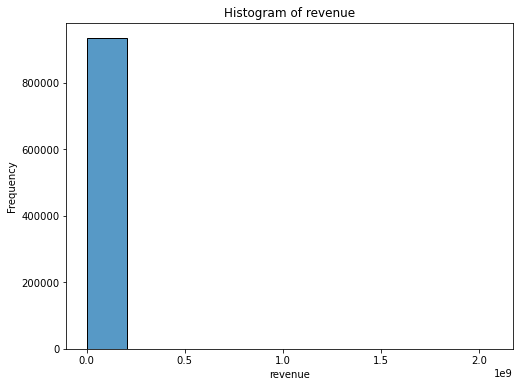

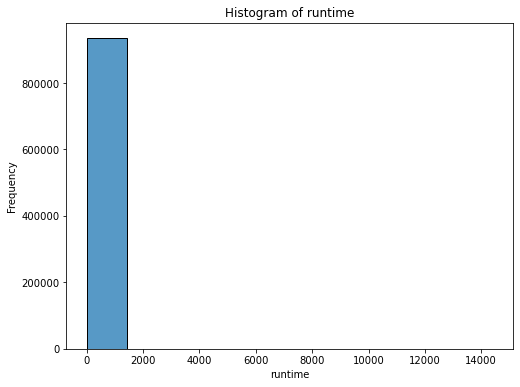

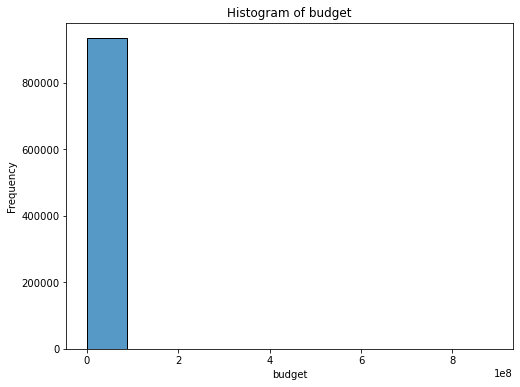

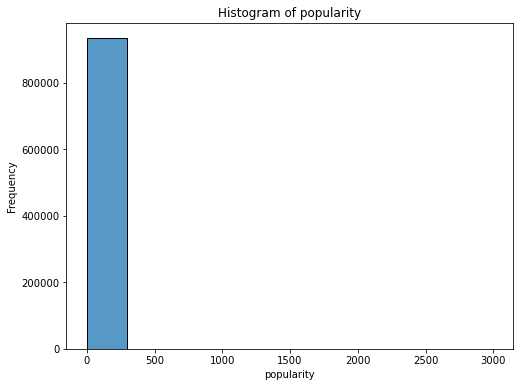

In [15]:
plotHistogram (moviesDF)

### Data Manipulation and Feature Extraction

In [16]:
from pyspark.sql.functions import year
moviesDF = moviesDF.withColumn("release_year", year("release_date"))
numericalColumns.append("release_year")

moviesDF.printSchema()

root
 |-- id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- vote_average: float (nullable = true)
 |-- vote_count: integer (nullable = true)
 |-- status: string (nullable = true)
 |-- release_date: date (nullable = true)
 |-- revenue: integer (nullable = true)
 |-- runtime: integer (nullable = true)
 |-- adult: boolean (nullable = true)
 |-- backdrop_path: string (nullable = true)
 |-- budget: integer (nullable = true)
 |-- homepage: string (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: float (nullable = true)
 |-- poster_path: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- spoken_languages: string (nullable = true)
 |-- release_year: integer (

In [17]:
# Drop columns that will not be used
moviesDF = moviesDF.drop("id")
# moviesDF = moviesDF.drop("title")
moviesDF = moviesDF.drop("adult")
moviesDF = moviesDF.drop("backdrop_path")
moviesDF = moviesDF.drop("homepage")
moviesDF = moviesDF.drop("imdb_id")
moviesDF = moviesDF.drop("original_language")
moviesDF = moviesDF.drop("original_title")
moviesDF = moviesDF.drop("homepage")
moviesDF = moviesDF.drop("overview")
moviesDF = moviesDF.drop("poster_path")
moviesDF = moviesDF.drop("tagline")
moviesDF = moviesDF.drop("production_companies")
moviesDF = moviesDF.drop("production_countries")
moviesDF = moviesDF.drop("spoken_languages")
moviesDF = moviesDF.drop("release_date")
moviesDF.toPandas().head()

,title,vote_average,vote_count,status,revenue,runtime,budget,popularity,genres,release_year
0,Inception,8.364,34495,Released,8.255328e+08,148,160000000,83.952003,"Action, Science Fiction, Adventure",2010.0
1,Interstellar,8.417,32571,Released,7.017292e+08,169,165000000,140.240997,"Adventure, Drama, Science Fiction",2014.0
2,The Dark Knight,8.512,30619,Released,1.004558e+09,152,185000000,130.643005,"Drama, Action, Crime, Thriller",2008.0
3,Avatar,7.573,29815,Released,NaN,162,237000000,79.931999,"Action, Adventure, Fantasy, Science Fiction",2009.0
4,The Avengers,7.710,29166,Released,1.518816e+09,143,220000000,98.082001,"Science Fiction, Action, Adventure",2012.0


In [18]:
moviesDF.select("release_year").toPandas().describe()

,release_year
count,850217.000000
mean,1998.653910
std,26.748655
min,1865.000000
25%,1988.000000
50%,2009.000000
75%,2018.000000
max,2099.000000


In [19]:
allMoviesDF = moviesDF

moviesDF = moviesDF.where("popularity > 0 AND genres IS NOT NULL AND runtime > 0 AND status = 'Released' AND release_year > 1900")
moviesDF.count()
#spark.sql("SELECT COUNT(release_year) FROM movies WHERE popularity > 0 AND genres IS NOT NULL AND runtime > 0 AND status = 'Released' AND release_year > 1980").show()

477957

In [20]:
moviesDF.toPandas().describe()

,vote_average,vote_count,revenue,runtime,budget,popularity,release_year
count,477957.000000,477957.000000,4.779530e+05,477957.000000,4.779570e+05,477957.000000,477957.000000
mean,3.192882,44.415774,1.474315e+06,69.572265,5.738069e+05,2.092083,1997.926631
std,3.252265,490.023659,2.359842e+07,60.881496,6.739161e+06,11.475749,26.740034
min,0.000000,0.000000,0.000000e+00,1.000000,0.000000e+00,0.600000,1901.000000
25%,0.000000,0.000000,0.000000e+00,25.000000,0.000000e+00,0.600000,1985.000000
50%,3.000000,1.000000,0.000000e+00,80.000000,0.000000e+00,0.713000,2009.000000
75%,6.016000,4.000000,0.000000e+00,96.000000,0.000000e+00,1.492000,2018.000000
max,10.000000,34495.000000,2.068224e+09,14400.000000,8.880000e+08,2994.356934,2025.000000


In [21]:
moviesDF.printSchema()

root
 |-- title: string (nullable = true)
 |-- vote_average: float (nullable = true)
 |-- vote_count: integer (nullable = true)
 |-- status: string (nullable = true)
 |-- revenue: integer (nullable = true)
 |-- runtime: integer (nullable = true)
 |-- budget: integer (nullable = true)
 |-- popularity: float (nullable = true)
 |-- genres: string (nullable = true)
 |-- release_year: integer (nullable = true)



In [22]:
moviesDF.toPandas().head()

,title,vote_average,vote_count,status,revenue,runtime,budget,popularity,genres,release_year
0,Inception,8.364,34495,Released,8.255328e+08,148,160000000,83.952003,"Action, Science Fiction, Adventure",2010
1,Interstellar,8.417,32571,Released,7.017292e+08,169,165000000,140.240997,"Adventure, Drama, Science Fiction",2014
2,The Dark Knight,8.512,30619,Released,1.004558e+09,152,185000000,130.643005,"Drama, Action, Crime, Thriller",2008
3,Avatar,7.573,29815,Released,NaN,162,237000000,79.931999,"Action, Adventure, Fantasy, Science Fiction",2009
4,The Avengers,7.710,29166,Released,1.518816e+09,143,220000000,98.082001,"Science Fiction, Action, Adventure",2012


### Missing values for new dataset

In [23]:
moviesDF.select([fn.count(fn.when(fn.col(c) == 0, c)).alias(c) for c in numericalColumns]).toPandas().head()

,vote_average,vote_count,revenue,runtime,budget,popularity,release_year
0,222483,222380,461166,0,444139,0,0


In [24]:
# moviesDF = moviesDF.drop("vote_average")
# moviesDF = moviesDF.drop("vote_count")
moviesDF = moviesDF.drop("revenue")
moviesDF = moviesDF.drop("budget")

# numericalColumns.remove("vote_average")
# numericalColumns.remove("vote_count")
numericalColumns.remove("revenue")
numericalColumns.remove("budget")

In [25]:
moviesDF.toPandas().head()

,title,vote_average,status,runtime,popularity,genres,release_year
0,Inception,8.364,Released,148,83.952003,"Action, Science Fiction, Adventure",2010
1,Interstellar,8.417,Released,169,140.240997,"Adventure, Drama, Science Fiction",2014
2,The Dark Knight,8.512,Released,152,130.643005,"Drama, Action, Crime, Thriller",2008
3,Avatar,7.573,Released,162,79.931999,"Action, Adventure, Fantasy, Science Fiction",2009
4,The Avengers,7.710,Released,143,98.082001,"Science Fiction, Action, Adventure",2012


### Outliers

In [26]:
# Check for outliers
bounds = {}

for col in numericalColumns:
    quantiles = moviesDF.approxQuantile(col, [0.25, 0.75], 0.01)
    IQR = quantiles[1] - quantiles[0]
    bounds[col] = [quantiles[0] - 1.5 * IQR, quantiles[1] + 1.5 * IQR]
    
bounds

{'vote_average': [-9.028500080108643, 15.047500133514404],
 'runtime': [-81.5, 202.5],
 'popularity': [-0.7994999289512634, 2.932499945163727],
 'release_year': [1935.5, 2067.5]}

In [27]:
moviesDF.select([
    (
        (moviesDF[c] < bounds[c][0]) | 
        (moviesDF[c] > bounds[c][1])
    ).alias(c + '_o') for c in numericalColumns
]).toPandas().head(10)

,vote_average_o,runtime_o,popularity_o,release_year_o
0,False,False,True,False
1,False,False,True,False
2,False,False,True,False
3,False,False,True,False
4,False,False,True,False
5,False,False,True,False
6,False,False,True,False
7,False,False,True,False
8,False,False,True,False
9,False,False,True,False


### Binary encoding Genres

In [28]:
from pyspark.sql.functions import split, explode, udf, col, size, expr

tempDF = moviesDF.withColumn("genre_tokens", split(moviesDF["genres"], ","))
tempDF = tempDF.withColumn("genre_tokens", expr("TRANSFORM(genre_tokens, x -> TRIM(x))"))
tempDF = tempDF.withColumn("genre_count", size(col("genre_tokens")))

numericalColumns.append("genre_count")

In [29]:
uniqueGenres = sorted(set(token for row in tempDF.select("genre_tokens").collect() for token in row.genre_tokens))
uniqueGenres

['Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Science Fiction',
 'TV Movie',
 'Thriller',
 'War',
 'Western']

In [30]:
tempDF.toPandas().describe()

,vote_average,runtime,popularity,release_year,genre_count
count,477957.000000,477957.000000,477957.000000,477957.000000,477957.000000
mean,3.192882,69.572265,2.092083,1997.926631,1.584404
std,3.252265,60.881496,11.475749,26.740034,0.836106
min,0.000000,1.000000,0.600000,1901.000000,1.000000
25%,0.000000,25.000000,0.600000,1985.000000,1.000000
50%,3.000000,80.000000,0.713000,2009.000000,1.000000
75%,6.016000,96.000000,1.492000,2018.000000,2.000000
max,10.000000,14400.000000,2994.356934,2025.000000,16.000000


In [31]:
def createGenreIndicator(genre):
    return udf(lambda tokens: 1 if genre in tokens else 0, IntegerType())

for genre in uniqueGenres:
    indicator = genre
    tempDF = tempDF.withColumn(indicator, createGenreIndicator(genre)(col("genre_tokens")))

In [32]:
tempDF.where("genre_count > 1").toPandas().head()

2023-10-08 12:22:42,675 WARN util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,title,vote_average,status,runtime,popularity,genres,release_year,genre_tokens,genre_count,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,Inception,8.364,Released,148,83.952003,"Action, Science Fiction, Adventure",2010,"[War, Science Fiction, Adventure]",3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,Interstellar,8.417,Released,169,140.240997,"Adventure, Drama, Science Fiction",2014,"[Adventure, Drama, Science Fiction]",3,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
2,The Dark Knight,8.512,Released,152,130.643005,"Drama, Action, Crime, Thriller",2008,"[Drama, Action, Crime, Thriller]",4,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
3,Avatar,7.573,Released,162,79.931999,"Action, Adventure, Fantasy, Science Fiction",2009,"[Action, Adventure, Fantasy, Science Fiction]",4,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
4,The Avengers,7.710,Released,143,98.082001,"Science Fiction, Action, Adventure",2012,"[Science Fiction, Action, Adventure]",3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [33]:
tempDF = tempDF.drop("genres")
tempDF = tempDF.drop("genre_tokens")

In [34]:
tempDF.toPandas().head(5)

,title,vote_average,status,runtime,popularity,release_year,genre_count,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,Inception,8.364,Released,148,83.952003,2010,3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,Interstellar,8.417,Released,169,140.240997,2014,3,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
2,The Dark Knight,8.512,Released,152,130.643005,2008,4,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
3,Avatar,7.573,Released,162,79.931999,2009,4,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
4,The Avengers,7.710,Released,143,98.082001,2012,3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [35]:
moviesDF = tempDF

In [36]:
moviesDF.toPandas().describe()

,vote_average,runtime,popularity,release_year,genre_count,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
count,477957.000000,477957.000000,477957.000000,477957.000000,477957.000000,477957.000000,477957.000000,477957.000000,477957.000000,477957.000000,477957.000000,477957.000000,477957.000000,477957.000000,477957.000000,477957.000000,477957.000000,477957.000000,477957.000000,477957.000000,477957.000000,477957.000000,477957.000000,477957.000000
mean,3.192882,69.572265,2.092083,1997.926631,1.584404,0.071069,0.037248,0.090328,0.208801,0.054312,0.232188,0.350452,0.042276,0.034750,0.025186,0.077350,0.064581,0.030706,0.086815,0.033654,0.038654,0.073622,0.016943,0.014939
std,3.252265,60.881496,11.475749,26.740034,0.836106,0.256941,0.189369,0.286652,0.406452,0.226633,0.422229,0.477112,0.201218,0.183146,0.156691,0.267146,0.245786,0.172519,0.281565,0.180336,0.192769,0.261155,0.129058,0.121307
min,0.000000,1.000000,0.600000,1901.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,25.000000,0.600000,1985.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,80.000000,0.713000,2009.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.016000,96.000000,1.492000,2018.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,10.000000,14400.000000,2994.356934,2025.000000,16.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [37]:
moviesDF.where("genre_count = 16").toPandas().head()

,title,vote_average,status,runtime,popularity,release_year,genre_count,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,Nincet Ninety,0.0,Released,13,0.6,2012,16,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1


In [38]:
moviesDF.toPandas().head()

,title,vote_average,status,runtime,popularity,release_year,genre_count,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,Inception,8.364,Released,148,83.952003,2010,3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,Interstellar,8.417,Released,169,140.240997,2014,3,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
2,The Dark Knight,8.512,Released,152,130.643005,2008,4,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
3,Avatar,7.573,Released,162,79.931999,2009,4,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
4,The Avengers,7.710,Released,143,98.082001,2012,3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


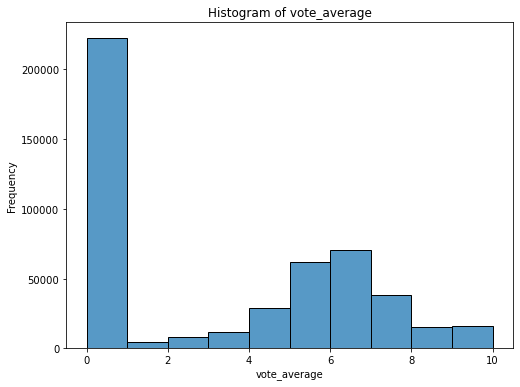

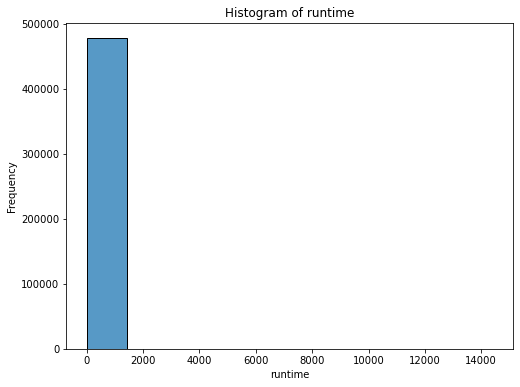

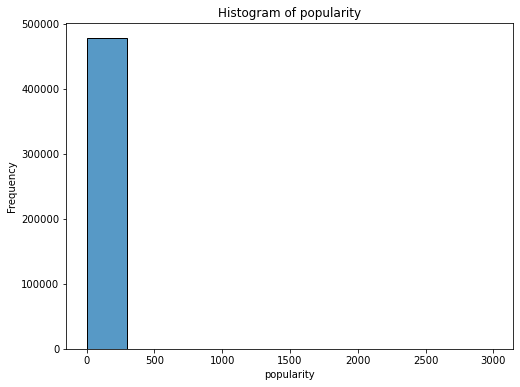

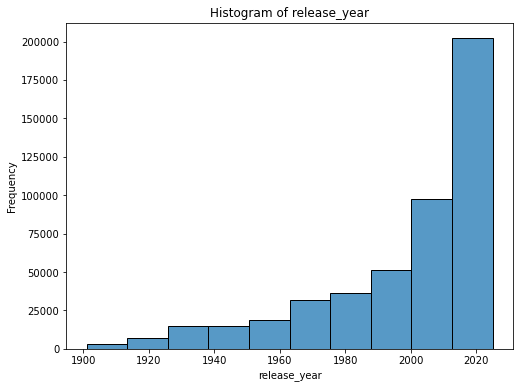

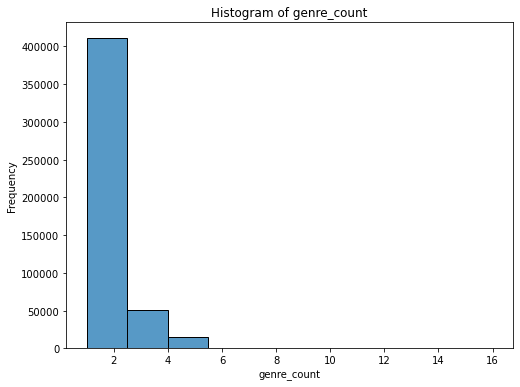

In [39]:
plotHistogram(moviesDF)

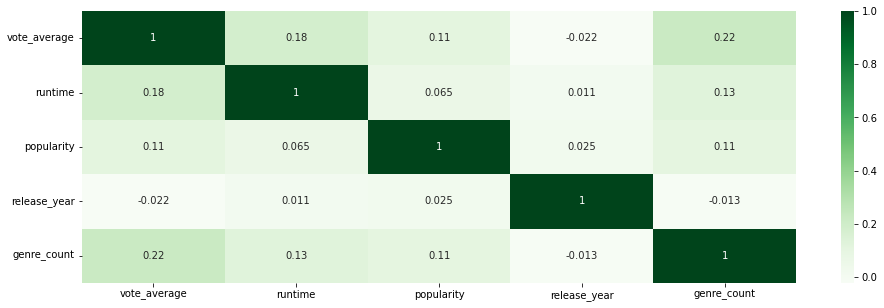

In [40]:
plotCorrelation(moviesDF)

In [41]:
def plotBoxPlot (df):
    for column in numericalColumns:
        tempPanda = df.select(column).toPandas()
        plt.figure(figsize = (8,6))
        sns.boxplot(x = tempPanda[column])
        plt.xlabel(column)
        plt.title(f"Box plot of {column}")
        plt.show()

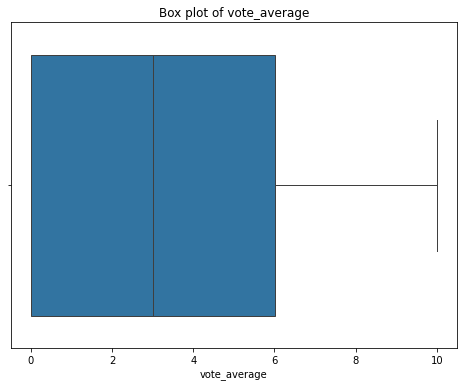

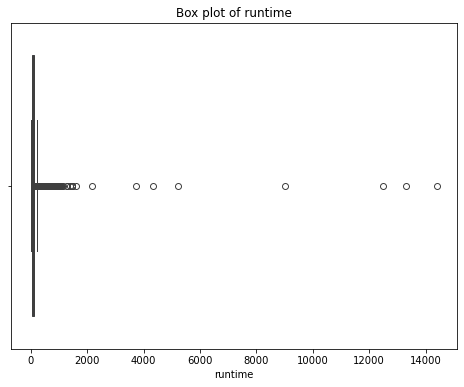

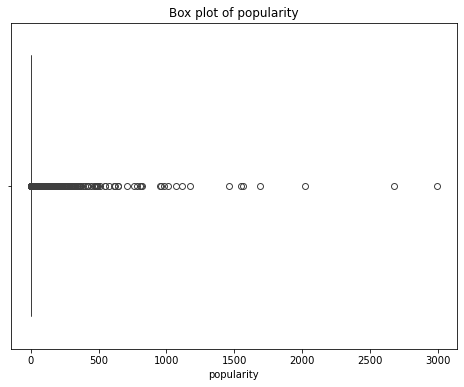

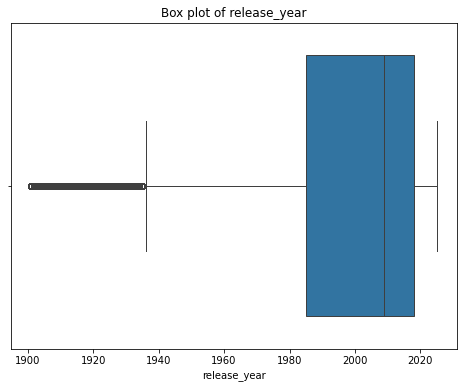

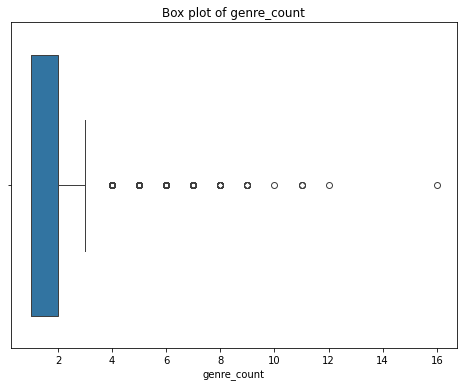

In [42]:
plotBoxPlot (moviesDF)

In [43]:
moviesDF.where("runtime <= 96").count()

363071

In [44]:
tempDF1980 = moviesDF.where("runtime < 180")

In [45]:
tempDF1980.count()

471590

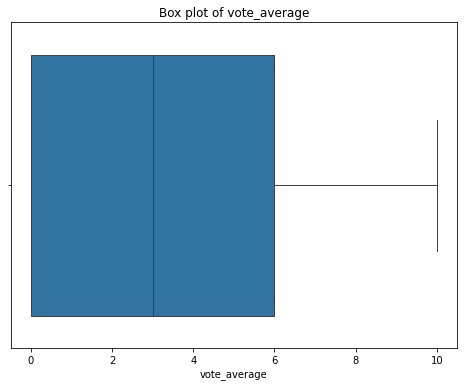

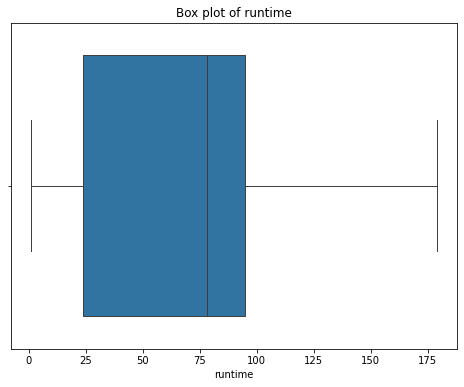

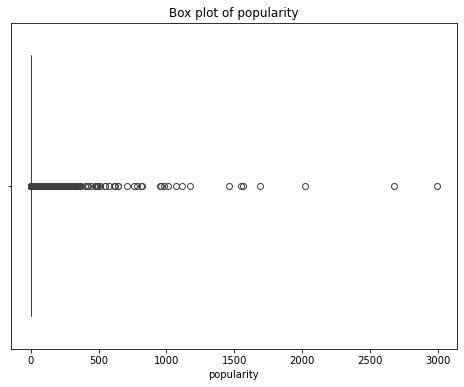

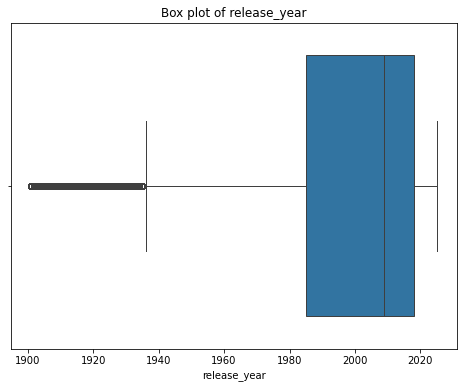

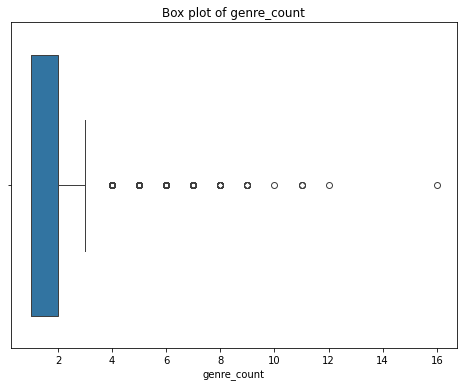

In [46]:
plotBoxPlot (tempDF1980)

### Save the cleaned data

In [47]:
cleanedDataPath = "/CA1/data/cleaned"
moviesDF.write.csv(cleanedDataPath, header=True, mode="overwrite")

----------------------------------------                                        
Exception occurred during processing of request from ('127.0.0.1', 58896)
Traceback (most recent call last):
  File "/usr/lib/python3.10/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.10/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.10/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.10/socketserver.py", line 747, in __init__
    self.handle()
  File "/usr/local/spark/python/pyspark/accumulators.py", line 262, in handle
    poll(accum_updates)
  File "/usr/local/spark/python/pyspark/accumulators.py", line 235, in poll
    if func():
  File "/usr/local/spark/python/pyspark/accumulators.py", line 239, in accum_updates
    num_updates = read_int(self.rfile)
  File "/usr/loc